# Establishing Food Business in Hyderabad
### Applied Data Science Capstone Project by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Business problem](#business)
* [Data acquisition & Cleaning](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# 1. Introduction <a name="introduction"></a>

Hyderabad is one of the fastest growing cities in India, with this rapid growth in and around the city, the doors are open for the huge workforce increasing the city population and also the potential for the new and innovative businesses due to the bigger market availabilty. One of the fastest growing line of business which is evergreen is the food business. However, considering the diverse population of the city it is essential to understand the tastes and the locations in the city before entering into the business. Before venturing this highly diverse city the ideal location of the establishment and the cuisine liked by most of population must be decided.

# 2. Business problem <a name="business"></a>

The objective of this project is to analyze and select the best locations in the city of Hyderabad, India, to open a new restaurent. This project is mainly focused on geospatial analysis of the Hyderabad City and to determine the best possible location and cusine for the new restauant. Using data science methodology and machine learning techniques like clustering, let's try to answer the business question - What could be the ideal location to establish the new restaurent and what cuisine is mostly welcomed by the residents of Hyderabad?

# 3. Data acquisition & Cleaning <a name="data"></a>

### 3.1 Data Requirements

To answer the above business problem, we need the following data:
 1. List of all the areas in Hyderabad City. 
 2. Geospatial coordinates of the areas in the city
 3. Data of different venues in City 

### 3.2 Data Sources

The list of areas/neighbourhoods in city can be extracted from this [wikedia page](https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Hyderabad,_India "wikedia page"). The scrapping of the html page can be done using the python requests and beatifulsoup package. THe extracted data can then be converted into a dataframe using pandas.

The geospatial coordinates of all the areas/neaighbourhoods can be extracted using the geopy and geo-coder packages. Passing the values extracted in scrapping through the geocoder user agent and fetching the geospatial coordinates. Then the entire data set extracted can be convereted into a dataframe using pandas.

Foursquare API can be used to fetch the venues data in the city and the using clustering on this data the business question can be answered.

# 4. Methodology <a name="methodology"></a>

Let's import all the required packages for the project

In [ ]:
from bs4 import BeautifulSoup

import urllib.request
from urllib.request import urlopen

import pandas as pd # library for data analsysis

import requests # library to handle requests

import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import numpy as np
from sklearn.cluster import KMeans # import k-means from clustering stage

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

# used to convert an address into latitude and longitude values
!pip install geopy 
from geopy.geocoders import Nominatim

print('Geopy Installed Successfully')

# map rendering library
!pip install folium
import folium

#library to visualize the k-means clustering performance
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer 
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance


print('All required Libraries imported!')

### 4.1 Scrapping data from the wikipedia page

Open the wikipedia page and read the text usinf beautifulsoup

In [2]:
d = urlopen('https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Hyderabad,_India')

soup = BeautifulSoup(d, 'xml')

Filter the xml text to the main table where the data to be extracted in available

In [3]:
content = soup.find('div', class_='mw-content-ltr')

Creating a list *hyderabad* and appending all the area names into that list from the filtered data above

In [4]:
hyderabad = []

for ul in content.find_all('ul'):
    for li in ul.find_all('li'):
        v = li.text.strip('\n')
        hyderabad.append(v)

Converting the list to dataframe so that it can utilized in the project

In [5]:
hyd = pd.DataFrame(hyderabad, columns = ['Area_Name'])
hyd = hyd.drop([0,1])
hyd.shape

(199, 1)

### 4.2 Fetching geospatial coordinates

Initializing the geocoder agent to fetch the geospatial coordinates

In [6]:
geolocator = Nominatim(user_agent="to_explorer")

def get_coordinates(area):
    try:
        location = geolocator.geocode('{}, Hyderabad, India'.format(area))
        ar = area
        latitude = location.latitude
        longitude = location.longitude
        return [ar, latitude, longitude]
    except:
        return [None, None, None]

Fetch the coordinates for all the areas extracted using geocoder and creating a list

In [7]:
coords = [get_coordinates(area) for area in hyd["Area_Name"].tolist()]

Converting the list with geospactial data into a dataframe hyd_geo

In [8]:
column_names = ['Area_Name', 'Latitude', 'Longitude']
hyd_g = pd.DataFrame(coords, columns = column_names)
hyd_geo = hyd_g.dropna()
hyd_geo.shape

(165, 3)

### 4.3 Creating a folium map using the geospatial data prepared

Let's get the coordinates of the City to mark as centre on the folium map

In [9]:
address = 'Hyderabad'


location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hyderabad are 17.360589, 78.4740613.


Visualizing the geospatial data prepared using folium maps

In [10]:
# create map of hyderabad using latitude and longitude values
map_hyd = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(hyd_geo['Latitude'], hyd_geo['Longitude'], hyd_geo['Area_Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hyd)  
    
map_hyd

### 4.4 Using Foursquare API to retrieve the venues data

Initiating the foursquare API

In [11]:
# @hidden_cell
CLIENT_ID = 'V4TJYPHTQSOT4P5MKNQKDQQQREYBEXULMH4MDG31WFPZULDL' # your Foursquare ID
CLIENT_SECRET = '2XDJRQMVN3EPJ43PLDYVGTIZDKDVFOL5QEY3TBHTQP24UQQC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Creating to function *getNearbyVenues* to retrive the venues data of all the location in the Hyderabad City

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print('Loading nearby venues of ',name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area_Name', 
                  'Area_Latitude', 
                  'Area_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

Calling the function created and creating a dataframe with the retrived venues data

In [14]:
hyd_venues = getNearbyVenues(names=hyd_geo['Area_Name'],
                                   latitudes=hyd_geo['Latitude'],
                                   longitudes=hyd_geo['Longitude']
                                  )

Let's check the shape of the resultant dataframe having all the nearby venues details

In [15]:
hyd_venues.shape

(978, 7)

Now, let's check the resultant dataframe having all the nearby venues details

In [16]:
hyd_venues.head(5)

,Area_Name,Area_Latitude,Area_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,A. S. Rao Nagar,17.47995,78.556834,Cafe Coffee Day,17.481262,78.555077,Café
1,A. S. Rao Nagar,17.47995,78.556834,Max,17.478846,78.558801,Clothing Store
2,A. S. Rao Nagar,17.47995,78.556834,Swagath Grand,17.482022,78.553261,Indian Restaurant
3,A. S. Rao Nagar,17.47995,78.556834,Ratnadeep Supermarket,17.481483,78.554160,Department Store
4,A. S. Rao Nagar,17.47995,78.556834,China Town,17.480912,78.560210,Chinese Restaurant


Creating a dataframe *hyd_onehot* transposing the venue categories into columns using get_dummies

In [17]:
hyd_onehot = pd.get_dummies(hyd_venues[['Venue_Category']], prefix="", prefix_sep="")

# add Area_Name column back to dataframe
hyd_onehot['Area_Name'] = hyd_venues['Area_Name'] 

# move Area_Name column to the first column
fixed_columns = [hyd_onehot.columns[-1]] + list(hyd_onehot.columns[:-1])
hyd_onehot = hyd_onehot[fixed_columns]

hyd_onehot.head()

,Area_Name,ATM,Afghan Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,...,Stadium,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Theme Park,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Women's Store
0,A. S. Rao Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A. S. Rao Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A. S. Rao Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A. S. Rao Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A. S. Rao Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping the dataframe *hyd_onehot* on Area_Name and creating a new dataframe *hyd_grouped*

In [18]:
hyd_grouped = hyd_onehot.groupby('Area_Name').mean().reset_index()

Creating a function *return_most_common_venues* to sort the venues in descending order

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each area

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area_Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Area_Name'] = hyd_grouped['Area_Name']

for ind in np.arange(hyd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hyd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Area_Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A. S. Rao Nagar,Department Store,Diner,Indian Restaurant,Clothing Store,Chinese Restaurant,Electronics Store,Café,Women's Store,Farmers Market,Food & Drink Shop
1,Abhyudaya Nagar,Indian Restaurant,ATM,Mobile Phone Shop,Burger Joint,Hotel,Health & Beauty Service,Hockey Arena,Deli / Bodega,Department Store,Dessert Shop
2,Abids,Indian Restaurant,Hotel,Shoe Store,Juice Bar,Neighborhood,Department Store,Fast Food Restaurant,Diner,Mobile Phone Shop,Gift Shop
3,Adikmet,Gym,Ice Cream Shop,Café,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Food Truck
4,Aghapura,Bakery,Afghan Restaurant,Indian Restaurant,Platform,Electronics Store,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant


### 4.5 Clustering of Areas

Determining the optimum *k* value for clustering 

Creatin a dataframe for clustering

In [21]:
hyd_grouped_clustering = hyd_grouped.drop('Area_Name', 1)

Plotting __Elbow curve__ on diferent k values from 4 to 11

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


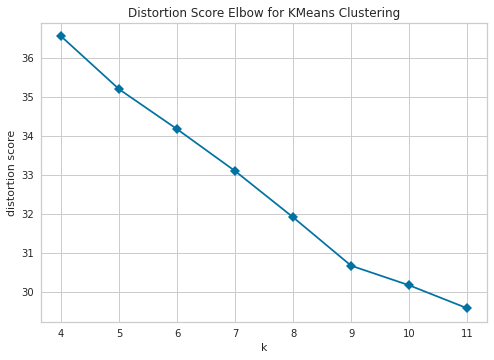

In [22]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(4,12), timings=False)
visualizer.fit(hyd_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Plotting __Silhouette curve__ on diferent k values from 3 to 11

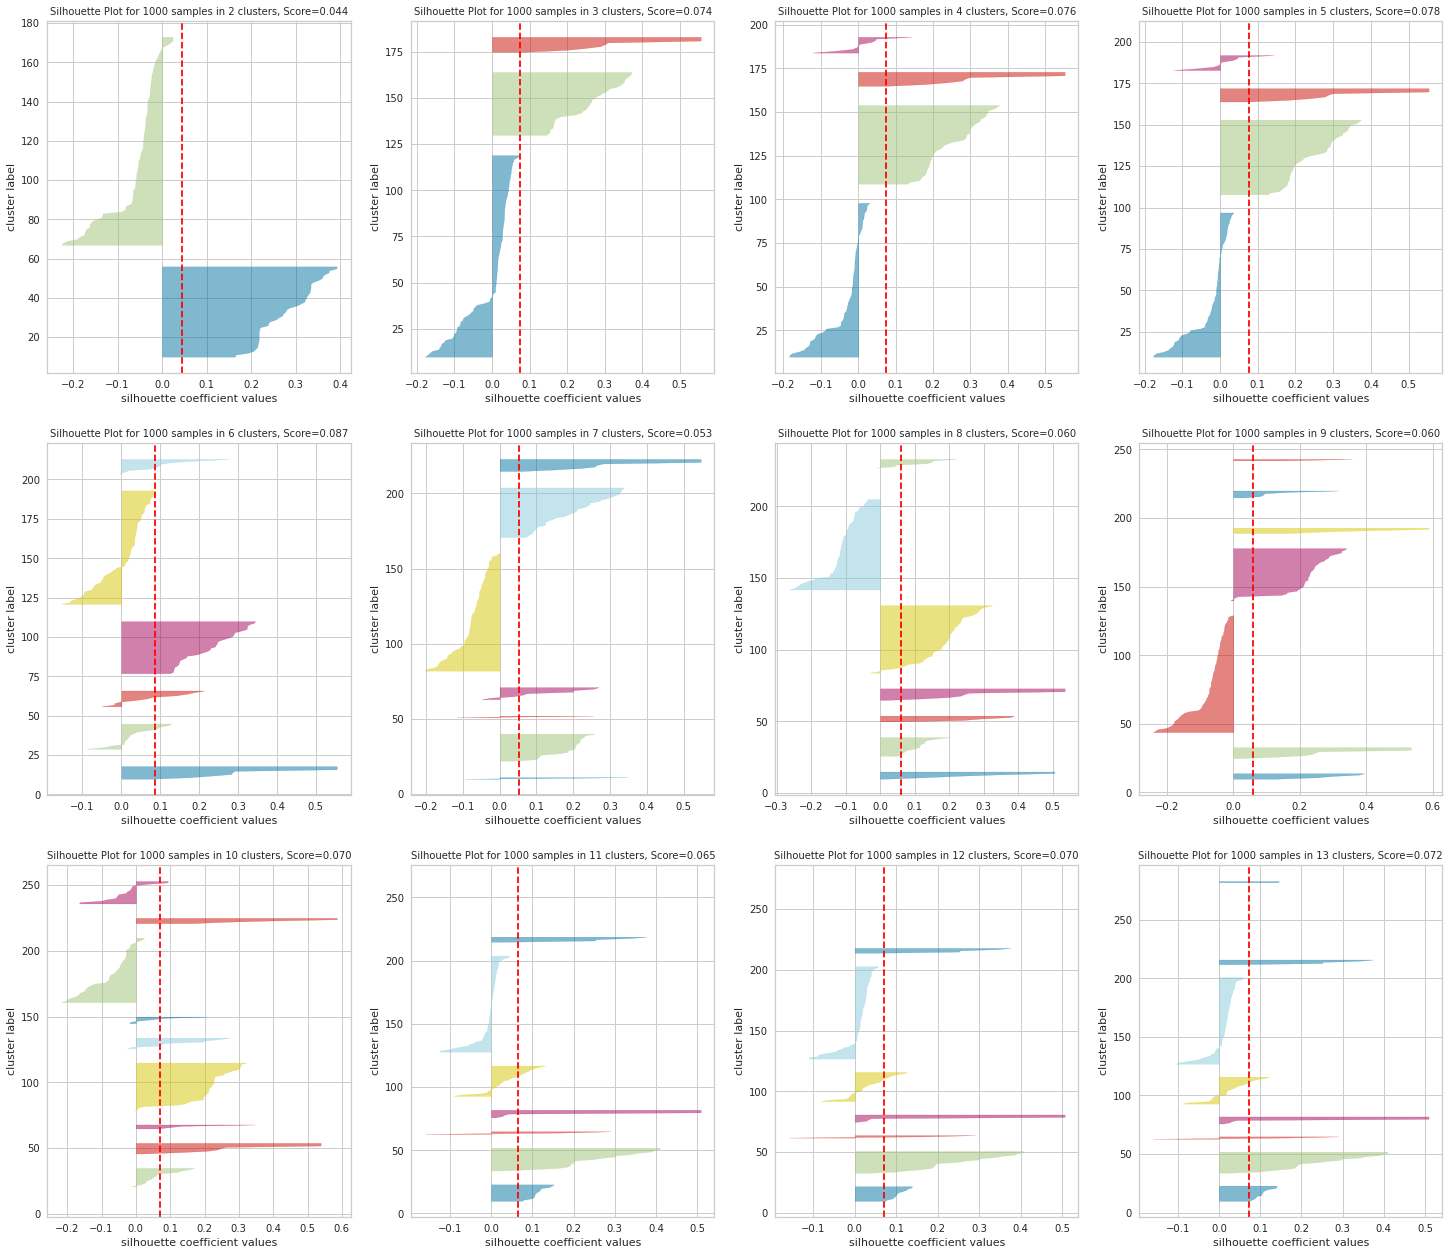

In [23]:
fig, axes = plt.subplots(3, 4, figsize=(25,22))
axes_flat = axes.flatten()                     # Flatted the axes to iterate
i=0
for k in range(2,14,1):
    model = KMeans(k, random_state=0)
    # Select the current axis
    ax=axes_flat[i]   
    # Creating SilhouetteVisualizer and assigning it to an axis
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes_flat[i] )
    visualizer.fit(hyd_grouped_clustering)
    # Setting subplot title via axis
    ax.set_title(f'Silhouette Plot for 1000 samples in {k} clusters, Score={visualizer.silhouette_score_:.3f}', fontsize=10)
    # Setting subplot x and y labels
    ax.set(xlabel='silhouette coefficient values', ylabel='cluster label')
    # Going to the next axis (subplot)
    i=i+1

plt.show()

From the Elbove curve and Silhouette curve we can drill down the *k* value to 7-9

Now, let's plot the Intercluster distance map for the *k* values 7-9 and determine the optimum k

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


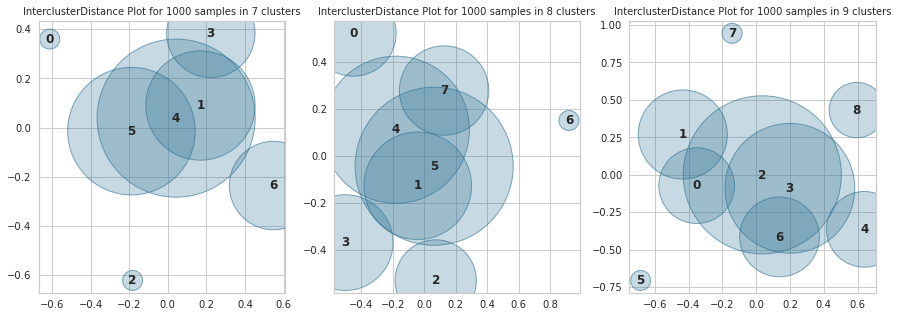

In [24]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes_flat = axes.flatten()                     # Flatted the axes to iterate
i=0
for k in range(7,10,1):
    model = KMeans(k, random_state=0)
    # Select the current axis
    ax=axes_flat[i]   
    # Creating InterclusterDistance and assigning it to an axis
    visualizer = InterclusterDistance(model, colors='yellowbrick', ax=axes_flat[i] )
    visualizer.fit(hyd_grouped_clustering)
    # Setting subplot title via axis
    ax.set_title(f'InterclusterDistance Plot for 1000 samples in {k} clusters', fontsize=10)
    # Setting subplot x and y labels
    #ax.set(xlabel='InterclusterDistance coefficient values', ylabel='cluster label')
    # Going to the next axis (subplot)
    i=i+1

plt.show()

The optimum *k* value can be picked as 9 the map above is clearly centered for k=8

Using k-means to cluster the neighborhood into 8 clusters.

In [25]:
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hyd_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([5, 4, 4, 5, 4, 3, 3, 5, 4, 4, 5, 5, 5, 0, 4, 4, 1, 3, 4, 1, 4, 5,
       1, 5, 4, 5, 5, 5, 7, 5, 1, 5, 6, 5, 4, 5, 5, 1, 5, 5, 2, 5, 5, 5,
       5, 0, 7, 5, 5, 4, 4, 5, 0, 1, 4, 4, 4, 7, 5, 4, 4, 1, 5, 7, 4, 4,
       1, 5, 5, 5, 5, 3, 5, 5, 5, 1, 5, 0, 0, 4, 4, 1, 5, 4, 5, 4, 4, 5,
       5, 5, 5, 2, 4, 5, 5, 4, 5, 5, 5, 4, 1, 4, 4, 5, 4, 5, 4, 5, 5, 7,
       3, 7, 5, 5, 4, 5, 7, 4, 1, 4, 4, 3, 4, 5, 4, 4, 4, 3, 3, 4, 5, 4,
       1, 3, 4, 4, 5, 4, 5, 0, 5, 5, 2, 5, 5, 2, 4, 5, 5, 1, 4, 2, 4, 5],
      dtype=int32)

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hyd_merged = hyd_geo

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
hyd_merged = hyd_merged.join(neighborhoods_venues_sorted.set_index('Area_Name'), on='Area_Name')

hyd_merged.head() # check the last columns!

,Area_Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A. S. Rao Nagar,17.479950,78.556834,5.0,Department Store,Diner,Indian Restaurant,Clothing Store,Chinese Restaurant,Electronics Store,Café,Women's Store,Farmers Market,Food & Drink Shop
1,Abhyudaya Nagar,17.337661,78.564716,4.0,Indian Restaurant,ATM,Mobile Phone Shop,Burger Joint,Hotel,Health & Beauty Service,Hockey Arena,Deli / Bodega,Department Store,Dessert Shop
2,Abids,17.389478,78.477182,4.0,Indian Restaurant,Hotel,Shoe Store,Juice Bar,Neighborhood,Department Store,Fast Food Restaurant,Diner,Mobile Phone Shop,Gift Shop
4,Adikmet,17.409550,78.513094,5.0,Gym,Ice Cream Shop,Café,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Food Truck
6,Aghapura,17.389178,78.465273,4.0,Bakery,Afghan Restaurant,Indian Restaurant,Platform,Electronics Store,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant


Let's check the unique cluster values in the dataframe *hyd_merged*

In [27]:
hyd_merged['Cluster Labels'].unique()

array([ 5.,  4.,  3., nan,  0.,  1.,  7.,  6.,  2.])

As there are *null* values in the dataframe, let's drop the rows with cluster value as null

In [28]:
hyd_merged.dropna(subset = ['Cluster Labels'], inplace=True)

Now, let's re-check the unique cluster values in the dataframe hyd_merged

In [29]:
hyd_merged['Cluster Labels'].unique()

array([5., 4., 3., 0., 1., 7., 6., 2.])

Visualizing the clusters using folium map

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hyd_merged['Latitude'], hyd_merged['Longitude'], hyd_merged['Area_Name'], hyd_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4.6 Choosing the correct cluster for setting up the Food Business

From the above visualization, it is clearly visible that the cluster 4 is dense and more aligned to the centre of the City
So, let us check the areas which are clustered under cluster 4

In [31]:
hyd_merged.loc[hyd_merged['Cluster Labels'] == 4, hyd_merged.columns[[0] + list(range(4, hyd_merged.shape[1]))]]

,Area_Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Abhyudaya Nagar,Indian Restaurant,ATM,Mobile Phone Shop,Burger Joint,Hotel,Health & Beauty Service,Hockey Arena,Deli / Bodega,Department Store,Dessert Shop
2,Abids,Indian Restaurant,Hotel,Shoe Store,Juice Bar,Neighborhood,Department Store,Fast Food Restaurant,Diner,Mobile Phone Shop,Gift Shop
6,Aghapura,Bakery,Afghan Restaurant,Indian Restaurant,Platform,Electronics Store,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant
11,Amberpet,Indian Restaurant,Movie Theater,Women's Store,Falafel Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant,Farmers Market
13,Ameerpet,Indian Restaurant,Department Store,Sandwich Place,Juice Bar,Hotel,Vegetarian / Vegan Restaurant,Food Court,Diner,Supermarket,Candy Store
20,Badichowdi,Hotel,Indian Restaurant,Bus Station,Multiplex,Indie Movie Theater,Bakery,Coffee Shop,Dumpling Restaurant,Electronics Store,Donut Shop
24,Balkampet,Indian Restaurant,Hockey Arena,Train Station,Light Rail Station,Bakery,Women's Store,Falafel Restaurant,Food & Drink Shop,Food,Flea Market
26,"Bank Street, Hyderabad",Indian Restaurant,Juice Bar,Department Store,Chaat Place,South Indian Restaurant,Women's Store,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant
30,Bazarghat,Hyderabadi Restaurant,Indian Restaurant,Bakery,Coffee Shop,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Café,Ice Cream Shop,Bank,Bus Station
34,"BHEL Township, Hyderabad",Indian Restaurant,Bakery,Bus Station,Ice Cream Shop,Falafel Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant


Creating a Dataframe with the venue details of all the areas under cluster 3

In [32]:
area_pref = pd.DataFrame(hyd_merged.loc[hyd_merged['Cluster Labels'] == 4, hyd_merged.columns[0]])
area_pref.shape

(48, 1)

### 4.7 Choosing best cuisines in the selected cluster for setting up the Food Business

Now, as we have picked a cluster in which we have the maximum potential for our fod business. Let's now find out the cuisines which should be choosen for our restaurent

Creating a dataframe *Hyd_res* by filtering the venues data extracted through foursquare API for venue category of *'Restaurant'*

In [33]:
Hyd_res = hyd_venues[hyd_venues['Venue_Category'].str.contains('Restaurant').reset_index(drop=True)]
Hyd_res.head()

,Area_Name,Area_Latitude,Area_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
2,A. S. Rao Nagar,17.479950,78.556834,Swagath Grand,17.482022,78.553261,Indian Restaurant
4,A. S. Rao Nagar,17.479950,78.556834,China Town,17.480912,78.560210,Chinese Restaurant
8,Abhyudaya Nagar,17.337661,78.564716,surabhi Restaurant,17.338986,78.565894,Indian Restaurant
11,Abhyudaya Nagar,17.337661,78.564716,Spicy Village,17.340282,78.565883,Indian Restaurant
14,Abids,17.389478,78.477182,Grand Hotel,17.387760,78.477577,Indian Restaurant


Grouping the data of *Hyd_res* to find the count of venues by *Area_Name* and *Venue_Category* 

In [34]:
hyd_res = Hyd_res.groupby(['Area_Name', 'Venue_Category']).count().reset_index()

hyd_res = hyd_res.drop(['Area_Latitude', 'Area_Longitude', 'Venue_Latitude', 'Venue_Longitude'], axis=1)

hyd_res.head()

,Area_Name,Venue_Category,Venue
0,A. S. Rao Nagar,Chinese Restaurant,1
1,A. S. Rao Nagar,Indian Restaurant,1
2,Abhyudaya Nagar,Indian Restaurant,2
3,Abids,Fast Food Restaurant,1
4,Abids,Indian Restaurant,5


Let's check the number of unique type of cuisines

In [35]:
print('There are {} uniques cuisines.'.format(len(hyd_res['Venue_Category'].unique())))

There are 23 uniques cuisines.


Creating a pivot table to check the no. of restaurants of different cuisines and areas

In [36]:
pivot_hyd = hyd_res.pivot_table(index='Area_Name', columns='Venue_Category', values='Venue', aggfunc='sum', fill_value=0)
pivot_hyd.head()

Venue_Category,Afghan Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,Greek Restaurant,Hyderabadi Restaurant,Indian Restaurant,Italian Restaurant,...,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Punjabi Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
Area_Name,,,,,,,,,,,,,,,,,,,,,
A. S. Rao Nagar,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Abhyudaya Nagar,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
Abids,0,0,0,0,0,1,0,0,5,0,...,0,0,0,0,0,0,1,0,0,0
Aghapura,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Amberpet,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Plotting the pivot table as a bar chart to visualize the data

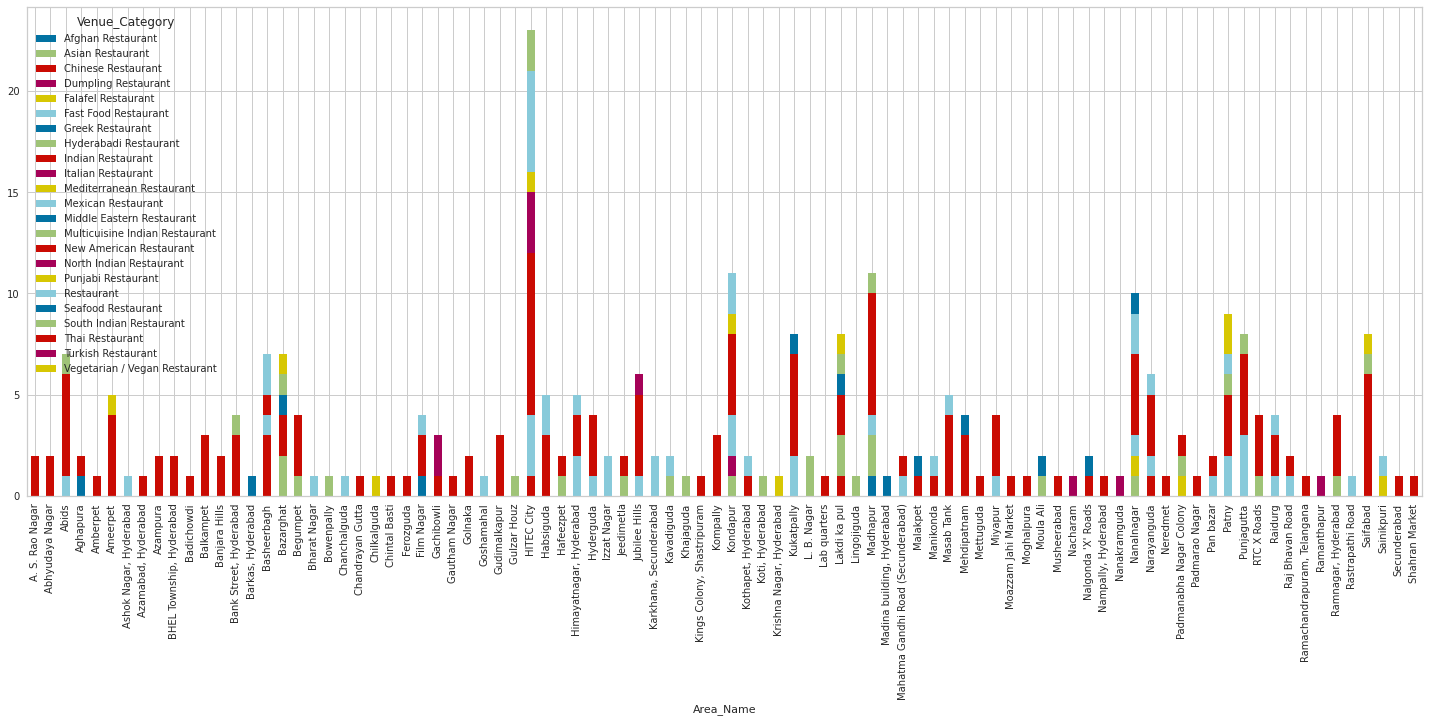

In [37]:
pivot_hyd.plot.bar(stacked=True, figsize=(25,9))

As we have seen how the different cuisines are spread over different areas in the City. Let us now focus only on the areas under the cluster 3

Creating dataframe of all restaurents in the areas belonging to Cluster 3

In [38]:
Res_c4 = area_pref.join(Hyd_res.set_index('Area_Name'), on='Area_Name')

Let's check the number of unique areas after merge

In [40]:
len(Res_c4['Area_Name'].unique())

48

Grouping the data of *Res_c4* to find the count of venues by *Area_Name* and *Venue_Category* 

In [41]:
res_c4 = Res_c4.groupby(['Area_Name', 'Venue_Category']).count().reset_index()

res_c4 = res_c4.drop(['Area_Latitude', 'Area_Longitude', 'Venue_Latitude', 'Venue_Longitude'], axis=1)

In [42]:
print('There are {} uniques cuisines.'.format(len(res_c4['Venue_Category'].unique())))

There are 19 uniques cuisines.


Creating a pivot table to check the no. of restaurants of different cuisines and areas of the cluster

In [44]:
pivot_c4 = res_c4.pivot_table(index='Venue_Category', columns='Area_Name', values='Venue', aggfunc='sum', fill_value=0)
pivot_c4

Area_Name,Abhyudaya Nagar,Abids,Aghapura,Amberpet,Ameerpet,"BHEL Township, Hyderabad",Badichowdi,Balkampet,"Bank Street, Hyderabad",Bazarghat,...,Padmarao Nagar,Pan bazar,Patny,Punjagutta,RTC X Roads,Raidurg,"Ramachandrapuram, Telangana",Saifabad,Secunderabad,Shahran Market
Venue_Category,,,,,,,,,,,,,,,,,,,,,
Afghan Restaurant,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Asian Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Chinese Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dumpling Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Falafel Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fast Food Restaurant,0,1,0,0,0,0,0,0,0,0,...,0,1,2,3,0,1,0,0,0,0
Hyderabadi Restaurant,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
Indian Restaurant,2,5,1,1,4,2,1,3,3,2,...,1,1,3,4,3,2,1,6,1,1
Italian Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Plotting the pivot table as a bar chart to visualize the data

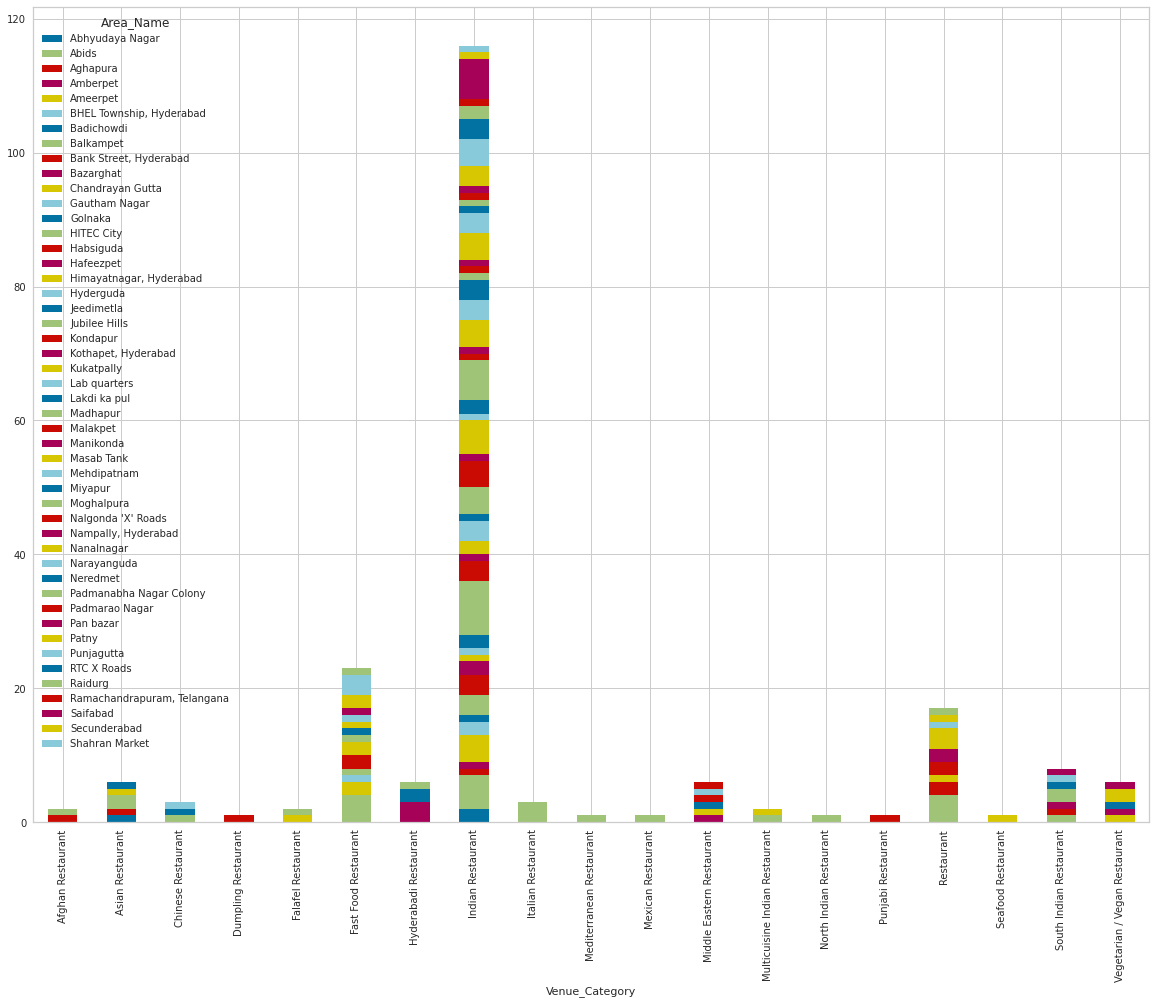

In [45]:
pivot_c4.plot.bar(stacked=True, figsize=(20,15))

From the above bar graph we can see top 3 cuisines in the cluster are:

1. Indian Cuisine
2. Chinese Cuisine
3. South Indian Cuisine

# 5. Results and Discussion  <a name="results"></a>

In this study, we have extracted the area/neighbourhood data from the wikipedia page using the python packages beatifulsoup and requests. The resultant data set has a total of 165 areas. These using the foursquare API we have fetched the venues data for the 165 areas in the city. There are total of 978 venues retrieved for all the areas in the city.

Using k-means clustering we tried to group the areas based on the venue categories. For determining the optimum *k* value, the elbow curve, silhouette curve and inter cluster distance techniques are used. Then, plotting the clusters using folium map the most appropriate cluster is picked. Assuming that the population will be high at the centre of the city, the cluster which is dense and more aligned to the city center is considered the optimal choice.

Filtering the venue categories for only restaurents, we can see the total unique cuisines in the city are 23. Further narrowing the search to the cluster picked, the number uniques cuisines is 19 for the 48 areas in the cluster.

Using the bar plot, we can visualize the most commen cusines and pick the top cusines.

# 6. Conclusion <a name="conclusion"></a>

Purpose of this project is to identify the best possible location and cuisine to set up a food business/restaurent in the Hyderabad city. By calculating the venues density and the alignment of the differnt similar venues to the centre of the city we had narrowed down the search for the appropiate location (cluster). Also, the top cuisnies with that cluster are identified which will help the stakeholder to decide on the type of restaurant. 

The final decision on the optimal location can be made by the stakeholders considering other factors such as real-estate, population, levels of noise / proximity to major roads of the locations in the recommended cluster